# Notebook 05: Age-Disease Intersection Analysis

**Kairos Therapeutics ML Prototype V0**

---

## Strategic Context

**Kairos Therapeutics: Causal gene-intervention discovery engine for aging biology**

- Aging is the root cause
- Diseases (OA, neurodegeneration, fibrosis) are manifestations
- Genes are controllable levers
- MSCs / gene editing are delivery mechanisms

## Purpose of This Notebook

Identify genes at the **intersection of disease dysregulation AND aging biology**:
1. Load OA differential expression results
2. Integrate multiple aging gene signatures (GenAge, SenMayo, SASP)
3. Find intersection: OA-dysregulated AND aging-associated
4. Filter for **secreted factors** (MSC-deliverable candidates)
5. Prepare prioritized list for Notebook 06

## Inputs
- `data/processed/GSE114007_diff_expr_results.csv`
- `data/processed/GSE114007_significant_genes.csv`
- `data/processed/intervention_candidates.csv`
- Curated aging gene signatures (defined in this notebook)

## Outputs
- `data/processed/aging_gene_signatures.csv`
- `data/processed/age_disease_intersection.csv`
- `data/processed/secreted_candidates.csv`
- `reports/figures/age_disease_venn.png`
- `reports/figures/secreted_candidates_plot.png`
- `reports/age_disease_intersection_summary.txt`

## Author
Pat Ovando-Roche, PhD | Kairos Therapeutics

## Version
v0.1 | December 2025

---
## Cell 1: Setup and Load Data

In [1]:
"""
CELL 1: SETUP AND LOAD DATA
===========================
Load differential expression results from Notebook 03.
"""

import os
import warnings
from pathlib import Path
from datetime import datetime
from collections import defaultdict

warnings.filterwarnings('ignore')

# Core data science
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn3

# Set plotting defaults
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

# --- Determine paths ---
NOTEBOOK_DIR = Path(os.getcwd())
if NOTEBOOK_DIR.name == 'notebooks':
    PROJECT_ROOT = NOTEBOOK_DIR.parent
else:
    PROJECT_ROOT = NOTEBOOK_DIR

DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
FIGURES_DIR = PROJECT_ROOT / 'reports' / 'figures'
REPORTS_DIR = PROJECT_ROOT / 'reports'

# Create output directories
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

print("="*70)
print("NOTEBOOK 05: AGE-DISEASE INTERSECTION ANALYSIS")
print("="*70)
print()
print("Target: Genes at intersection of OA dysregulation AND aging biology")
print("Goal: Identify MSC-deliverable therapeutic candidates")
print()
print(f"Project root: {PROJECT_ROOT}")
print(f"Data folder: {DATA_PROCESSED}")
print()

# --- Load DE results ---
print("Loading differential expression results...")
print()

try:
    de_results = pd.read_csv(DATA_PROCESSED / 'GSE114007_diff_expr_results.csv')
    print(f"   Full DE results: {de_results.shape}")
except FileNotFoundError:
    print("   DE results not found - run Notebook 03 first")
    de_results = None

try:
    sig_genes = pd.read_csv(DATA_PROCESSED / 'GSE114007_significant_genes.csv')
    print(f"   Significant genes: {sig_genes.shape}")
except FileNotFoundError:
    print("   Significant genes not found")
    sig_genes = None

try:
    intervention_candidates = pd.read_csv(DATA_PROCESSED / 'intervention_candidates.csv')
    print(f"   Intervention candidates: {intervention_candidates.shape}")
except FileNotFoundError:
    print("   Intervention candidates not found")
    intervention_candidates = None

print()
print(f"Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print()
print("Cell 1 complete. Ready for Cell 2.")

NOTEBOOK 05: AGE-DISEASE INTERSECTION ANALYSIS

Target: Genes at intersection of OA dysregulation AND aging biology
Goal: Identify MSC-deliverable therapeutic candidates

Project root: C:\Users\povan\Kairos_Therapeutics
Data folder: C:\Users\povan\Kairos_Therapeutics\data\processed

Loading differential expression results...

   Full DE results: (23710, 13)
   Significant genes: (1269, 13)
   Intervention candidates: (479, 10)

Started: 2025-12-26 22:41:21

Cell 1 complete. Ready for Cell 2.


---
## Cell 2: Define Aging Gene Signatures

In [2]:
"""
CELL 2: DEFINE AGING GENE SIGNATURES
====================================
Curated gene lists from established aging databases and literature.

Sources:
- GenAge: Human Ageing Genomic Resources (genomics.senescence.info)
- SenMayo: Senescence marker panel (Saul et al., Aging Cell 2022)
- SASP: Senescence-Associated Secretory Phenotype (Coppe et al.)
- CellAge: Database of cell senescence genes

Note: These are curated subsets for V0. Full database integration in V1.
"""

print("DEFINING AGING GENE SIGNATURES")
print("="*70)
print()

# =============================================================================
# GenAge: Established human aging genes (curated core set)
# Source: https://genomics.senescence.info/genes/human.html
# =============================================================================
GENAGE_GENES = {
    # Longevity-associated genes
    'APOE', 'FOXO1', 'FOXO3', 'SIRT1', 'SIRT3', 'SIRT6', 'TERT', 'TERC',
    'IGF1', 'IGF1R', 'GH1', 'GHR', 'INS', 'INSR', 'IRS1', 'IRS2',
    'MTOR', 'RPTOR', 'RICTOR', 'AKT1', 'AKT2', 'PIK3CA', 'PTEN',
    'TP53', 'CDKN1A', 'CDKN2A', 'RB1', 'MDM2',
    'KLOTHO', 'LMNA', 'WRN', 'BLM', 'ERCC1', 'ERCC2', 'XPA',
    'SOD1', 'SOD2', 'CAT', 'GPX1', 'PRDX1',
    'ATM', 'ATR', 'BRCA1', 'BRCA2', 'RAD51',
    'HSPA1A', 'HSP90AA1', 'DNAJB1',
    'NFE2L2', 'KEAP1', 'NQO1', 'HMOX1',
    'PPARG', 'PPARGC1A', 'TFAM', 'NRF1',
    'AMPK', 'PRKAA1', 'PRKAA2', 'STK11',
    'BECN1', 'ATG5', 'ATG7', 'MAP1LC3B', 'SQSTM1',
    'IL6', 'IL1B', 'TNF', 'NFKB1', 'RELA',
    'TGFB1', 'TGFB2', 'TGFB3', 'BMP2', 'BMP4',
}

# =============================================================================
# SenMayo: Senescence marker panel (125 genes from Saul et al. 2022)
# Validated across multiple tissues and conditions
# =============================================================================
SENMAYO_GENES = {
    # Core senescence markers
    'CDKN1A', 'CDKN2A', 'CDKN2B', 'TP53', 'RB1',
    'GLB1', 'SERPINE1', 'IGFBP3', 'IGFBP5', 'IGFBP7',
    # Cell cycle arrest
    'CCND1', 'CCND2', 'CDK4', 'CDK6', 'E2F1', 'E2F3',
    # DNA damage response
    'ATM', 'ATR', 'CHEK1', 'CHEK2', 'H2AFX', 'TP53BP1',
    # SASP core factors
    'IL1A', 'IL1B', 'IL6', 'IL8', 'CXCL1', 'CXCL2', 'CXCL3',
    'CCL2', 'CCL3', 'CCL4', 'CCL5', 'CCL7', 'CCL8', 'CCL13',
    'CXCL10', 'CXCL11', 'CXCL12',
    'MMP1', 'MMP3', 'MMP9', 'MMP10', 'MMP12', 'MMP13', 'MMP14',
    'TIMP1', 'TIMP2',
    'VEGFA', 'VEGFC', 'FGF2', 'HGF', 'AREG', 'EREG',
    'TGFB1', 'TGFB2', 'BMP2', 'BMP6', 'GDF15',
    'SERPINE1', 'SERPINE2', 'SERPINB2',
    # Additional SenMayo markers
    'LMNB1', 'HMGB1', 'HMGB2',
    'NOTCH1', 'NOTCH3', 'JAG1',
    'WNT2', 'WNT5A', 'WNT16',
    'SPP1', 'FN1', 'THBS1', 'CTGF',
    'PLAUR', 'PLAU', 'PLAT',
    'ICAM1', 'VCAM1', 'SELE',
    'CSF1', 'CSF2', 'CSF3',
    'LIF', 'OSM', 'CNTF',
    'EDN1', 'NOS2', 'PTGS2',
    'TNFRSF10A', 'TNFRSF10B', 'FAS', 'FASLG',
}

# =============================================================================
# SASP: Senescence-Associated Secretory Phenotype (secreted factors)
# Core SASP factors that are secreted and could be MSC-delivered
# =============================================================================
SASP_GENES = {
    # Pro-inflammatory cytokines
    'IL1A', 'IL1B', 'IL6', 'IL8', 'IL18', 'TNF', 'TNFSF10',
    # Chemokines
    'CXCL1', 'CXCL2', 'CXCL3', 'CXCL5', 'CXCL6', 'CXCL8',
    'CXCL10', 'CXCL11', 'CXCL12', 'CXCL13', 'CXCL14',
    'CCL2', 'CCL3', 'CCL4', 'CCL5', 'CCL7', 'CCL8', 'CCL13', 'CCL20',
    'CX3CL1',
    # Growth factors
    'VEGFA', 'VEGFB', 'VEGFC', 'FGF2', 'FGF7', 'HGF', 'PDGFA', 'PDGFB',
    'AREG', 'EREG', 'HBEGF', 'BTC',
    'IGF1', 'IGFBP2', 'IGFBP3', 'IGFBP4', 'IGFBP5', 'IGFBP6', 'IGFBP7',
    'TGFB1', 'TGFB2', 'TGFB3', 'BMP2', 'BMP4', 'BMP6', 'GDF15',
    # Matrix remodeling
    'MMP1', 'MMP2', 'MMP3', 'MMP7', 'MMP9', 'MMP10', 'MMP12', 'MMP13', 'MMP14',
    'TIMP1', 'TIMP2', 'TIMP3',
    'SERPINE1', 'SERPINE2', 'SERPINB2',
    'PLAU', 'PLAUR', 'PLAT',
    # Other secreted factors
    'SPP1', 'FN1', 'THBS1', 'THBS2', 'CTGF', 'CYR61',
    'LIF', 'OSM', 'CNTF', 'CTF1',
    'CSF1', 'CSF2', 'CSF3',
    'ANGPT1', 'ANGPT2', 'ANGPTL4',
    'WNT5A', 'WNT16',
    'INHBA', 'INHA', 'FST',
    # Additional aging-related secreted factors
    'PF4', 'PPBP',  # Platelet factors (PF4 is official symbol; CXCL4 alias removed)
    'KLOTHO', 'GDF11', 'MANF', 'CDNF',
}

# =============================================================================
# Secretome: Human secreted proteins (for filtering MSC-deliverable candidates)
# Source: Human Protein Atlas secretome + UniProt signal peptide annotation
# =============================================================================
SECRETOME_GENES = {
    # Cytokines and chemokines (all secreted)
    'IL1A', 'IL1B', 'IL2', 'IL3', 'IL4', 'IL5', 'IL6', 'IL7', 'IL8', 'IL9',
    'IL10', 'IL11', 'IL12A', 'IL12B', 'IL13', 'IL15', 'IL17A', 'IL18', 'IL21', 'IL22',
    'TNF', 'TNFSF10', 'TNFSF11', 'LTA', 'LTB',
    'IFNG', 'IFNA1', 'IFNB1',
    'CXCL1', 'CXCL2', 'CXCL3', 'CXCL4', 'CXCL5', 'CXCL6', 'CXCL7', 'CXCL8',
    'CXCL9', 'CXCL10', 'CXCL11', 'CXCL12', 'CXCL13', 'CXCL14', 'CXCL16',
    'CCL1', 'CCL2', 'CCL3', 'CCL4', 'CCL5', 'CCL7', 'CCL8', 'CCL11', 'CCL13',
    'CCL17', 'CCL18', 'CCL19', 'CCL20', 'CCL21', 'CCL22', 'CCL24', 'CCL25', 'CCL26',
    'CX3CL1', 'XCL1',
    # Growth factors
    'VEGFA', 'VEGFB', 'VEGFC', 'VEGFD', 'PGF',
    'FGF1', 'FGF2', 'FGF4', 'FGF7', 'FGF9', 'FGF10', 'FGF18', 'FGF21', 'FGF23',
    'EGF', 'AREG', 'EREG', 'HBEGF', 'BTC', 'TGFA',
    'PDGFA', 'PDGFB', 'PDGFC', 'PDGFD',
    'HGF', 'MST1',
    'IGF1', 'IGF2',
    'TGFB1', 'TGFB2', 'TGFB3',
    'BMP2', 'BMP4', 'BMP6', 'BMP7', 'BMP9',
    'GDF5', 'GDF11', 'GDF15',
    'NGF', 'BDNF', 'NTF3', 'NTF4', 'GDNF',
    'LIF', 'OSM', 'CNTF', 'CTF1',
    'CSF1', 'CSF2', 'CSF3',
    'KITLG', 'FLT3LG', 'TPO', 'EPO',
    # ECM and matricellular proteins
    'FN1', 'VTN', 'TNC', 'THBS1', 'THBS2', 'SPARC', 'SPP1',
    'CTGF', 'CYR61', 'NOV', 'WISP1',
    'POSTN', 'TGFBI',
    # Serpins and protease inhibitors
    'SERPINE1', 'SERPINE2', 'SERPINB2', 'SERPINA1', 'SERPINC1',
    'TIMP1', 'TIMP2', 'TIMP3', 'TIMP4',
    # Matrix metalloproteinases (secreted)
    'MMP1', 'MMP2', 'MMP3', 'MMP7', 'MMP8', 'MMP9', 'MMP10', 'MMP11', 'MMP12', 'MMP13',
    # ADAMTS family
    'ADAMTS1', 'ADAMTS4', 'ADAMTS5',
    # IGF binding proteins
    'IGFBP1', 'IGFBP2', 'IGFBP3', 'IGFBP4', 'IGFBP5', 'IGFBP6', 'IGFBP7',
    # Complement factors
    'C3', 'C4A', 'C4B', 'CFB', 'CFD', 'CFH', 'CFI',
    # Coagulation factors
    'F2', 'F7', 'F9', 'F10', 'PLG', 'PLAU', 'PLAT',
    # Wnt pathway secreted factors
    'WNT1', 'WNT2', 'WNT3A', 'WNT5A', 'WNT7A', 'WNT10B', 'WNT16',
    'SFRP1', 'SFRP2', 'SFRP4', 'DKK1', 'DKK3',
    # Other important secreted factors
    'ANGPT1', 'ANGPT2', 'ANGPTL4',
    'INHBA', 'INHA', 'FST', 'FSTL1', 'FSTL3',
    'ADM', 'ADM2',
    'RETN', 'ADIPOQ', 'LEP',
    'APOE', 'CLU', 'APOD',
    'GAS6', 'PROS1',
    'TNFAIP6', 'CHI3L1', 'CHI3L2',
    'MANF', 'CDNF',
    'PF4', 'PPBP',  # Platelet factors
    'PTN', 'MDK',
    'NRG1', 'NRG2',
    'JAG1', 'JAG2', 'DLL1', 'DLL4',
    'SHH', 'IHH', 'DHH',
    'SLIT2', 'SLIT3',
    'SEMA3A', 'SEMA3C', 'SEMA3F',
    'EFNA1', 'EFNB1', 'EFNB2',
    'GRN', 'PGRN',
    'HTRA1',
    'LCN2', 'LCN1',
    'LIPG', 'LPL', 'LIPC',
    'LOXL2',
    'CTHRC1',
    'COMP', 'PRG4',
}

# Combine into master aging signature
ALL_AGING_GENES = GENAGE_GENES | SENMAYO_GENES | SASP_GENES

print(f"   GenAge genes: {len(GENAGE_GENES)}")
print(f"   SenMayo senescence markers: {len(SENMAYO_GENES)}")
print(f"   SASP secreted factors: {len(SASP_GENES)}")
print(f"   Secretome reference: {len(SECRETOME_GENES)}")
print()
print(f"   Combined aging signature: {len(ALL_AGING_GENES)} unique genes")
print()

# Store in DataFrame for export
aging_signature_records = []
for gene in sorted(ALL_AGING_GENES):
    aging_signature_records.append({
        'gene': gene,
        'in_GenAge': gene in GENAGE_GENES,
        'in_SenMayo': gene in SENMAYO_GENES,
        'in_SASP': gene in SASP_GENES,
        'is_secreted': gene in SECRETOME_GENES,
    })

aging_signatures_df = pd.DataFrame(aging_signature_records)
print(f"   Aging genes that are secreted: {aging_signatures_df['is_secreted'].sum()}")

print()
print("Cell 2 complete. Ready for Cell 3.")

DEFINING AGING GENE SIGNATURES

   GenAge genes: 75
   SenMayo senescence markers: 93
   SASP secreted factors: 98
   Secretome reference: 242

   Combined aging signature: 192 unique genes

   Aging genes that are secreted: 98

Cell 2 complete. Ready for Cell 3.


---
## Cell 3: Identify Age-Disease Intersection

In [3]:
"""
CELL 3: IDENTIFY AGE-DISEASE INTERSECTION
=========================================
Find genes that are:
1. Significantly dysregulated in OA (from Notebook 03)
2. Present in aging gene signatures

This intersection represents genes where disease biology meets aging biology.
"""

print("IDENTIFYING AGE-DISEASE INTERSECTION")
print("="*70)
print()

if sig_genes is not None:
    # Get OA-dysregulated genes
    oa_sig_genes = set(sig_genes['gene'].tolist())
    oa_up_genes = set(sig_genes[sig_genes['significance'] == 'Up in OA']['gene'].tolist())
    oa_down_genes = set(sig_genes[sig_genes['significance'] == 'Down in OA']['gene'].tolist())
    
    print(f"OA-dysregulated genes (FDR < 0.05, |log2FC| > 1):")
    print(f"   Total: {len(oa_sig_genes)}")
    print(f"   Up in OA: {len(oa_up_genes)}")
    print(f"   Down in OA: {len(oa_down_genes)}")
    print()
    
    # Calculate intersections
    intersection_all = oa_sig_genes & ALL_AGING_GENES
    intersection_genage = oa_sig_genes & GENAGE_GENES
    intersection_senmayo = oa_sig_genes & SENMAYO_GENES
    intersection_sasp = oa_sig_genes & SASP_GENES
    
    print(f"Intersection with aging signatures:")
    print(f"   OA sig AND Any aging signature: {len(intersection_all)}")
    print(f"   OA sig AND GenAge: {len(intersection_genage)}")
    print(f"   OA sig AND SenMayo: {len(intersection_senmayo)}")
    print(f"   OA sig AND SASP: {len(intersection_sasp)}")
    print()
    
    # Direction breakdown
    intersection_up = oa_up_genes & ALL_AGING_GENES
    intersection_down = oa_down_genes & ALL_AGING_GENES
    
    print(f"Direction of aging-associated genes in OA:")
    print(f"   Disease-elevated (Up in OA): {len(intersection_up)}")
    print(f"   Loss of protective signaling (Down in OA): {len(intersection_down)}")
    print()
    
    # Create intersection DataFrame with full annotation
    intersection_records = []
    
    for gene in intersection_all:
        gene_de = sig_genes[sig_genes['gene'] == gene].iloc[0]
        
        intersection_records.append({
            'gene': gene,
            'log2FC': gene_de['log2FC'],
            'FDR': gene_de['FDR'] if 'FDR' in gene_de else gene_de.get('p_value', np.nan),
            'direction': gene_de['significance'],
            'in_GenAge': gene in GENAGE_GENES,
            'in_SenMayo': gene in SENMAYO_GENES,
            'in_SASP': gene in SASP_GENES,
            'is_secreted': gene in SECRETOME_GENES,
            'n_aging_sources': sum([gene in GENAGE_GENES, gene in SENMAYO_GENES, gene in SASP_GENES]),
        })
    
    intersection_df = pd.DataFrame(intersection_records)
    intersection_df = intersection_df.sort_values('log2FC', key=abs, ascending=False)
    
    print(f"Created intersection DataFrame: {intersection_df.shape}")
    
else:
    print("ERROR: sig_genes not loaded")

print()
print("Cell 3 complete. Ready for Cell 4.")

IDENTIFYING AGE-DISEASE INTERSECTION

OA-dysregulated genes (FDR < 0.05, |log2FC| > 1):
   Total: 1269
   Up in OA: 642
   Down in OA: 627

Intersection with aging signatures:
   OA sig AND Any aging signature: 34
   OA sig AND GenAge: 6
   OA sig AND SenMayo: 21
   OA sig AND SASP: 19

Direction of aging-associated genes in OA:
   Disease-elevated (Up in OA): 23
   Loss of protective signaling (Down in OA): 11

Created intersection DataFrame: (34, 9)

Cell 3 complete. Ready for Cell 4.


---
## Cell 4: Display Top Age-Disease Intersection Genes

In [4]:
"""
CELL 4: DISPLAY TOP AGE-DISEASE INTERSECTION GENES
===================================================
Show genes with strongest evidence of aging + disease involvement.
"""

print("TOP AGE-DISEASE INTERSECTION GENES")
print("="*70)
print()

# Disease-elevated aging genes (potential targets for INHIBITION)
up_aging = intersection_df[intersection_df['direction'] == 'Up in OA'].copy()
up_aging = up_aging.sort_values('log2FC', ascending=False)

print("DISEASE-ELEVATED AGING GENES (Candidates for Inhibition)")
print("-"*70)
print(f"{'Gene':<12} {'log2FC':>8} {'GenAge':>8} {'SenMayo':>8} {'SASP':>6} {'Secreted':>10}")
print("-"*70)

for _, row in up_aging.head(20).iterrows():
    print(f"{row['gene']:<12} {row['log2FC']:>8.2f} {'Yes' if row['in_GenAge'] else '-':>8} "
          f"{'Yes' if row['in_SenMayo'] else '-':>8} {'Yes' if row['in_SASP'] else '-':>6} "
          f"{'Yes' if row['is_secreted'] else '-':>10}")

print()

# Loss of protective signaling (potential targets for RESTORATION)
down_aging = intersection_df[intersection_df['direction'] == 'Down in OA'].copy()
down_aging = down_aging.sort_values('log2FC', ascending=True)

print("LOSS OF PROTECTIVE SIGNALING (Candidates for Restoration)")
print("-"*70)
print(f"{'Gene':<12} {'log2FC':>8} {'GenAge':>8} {'SenMayo':>8} {'SASP':>6} {'Secreted':>10}")
print("-"*70)

for _, row in down_aging.head(20).iterrows():
    print(f"{row['gene']:<12} {row['log2FC']:>8.2f} {'Yes' if row['in_GenAge'] else '-':>8} "
          f"{'Yes' if row['in_SenMayo'] else '-':>8} {'Yes' if row['in_SASP'] else '-':>6} "
          f"{'Yes' if row['is_secreted'] else '-':>10}")

print()
print("Cell 4 complete. Ready for Cell 5.")

TOP AGE-DISEASE INTERSECTION GENES

DISEASE-ELEVATED AGING GENES (Candidates for Inhibition)
----------------------------------------------------------------------
Gene           log2FC   GenAge  SenMayo   SASP   Secreted
----------------------------------------------------------------------
MMP13            3.20        -      Yes    Yes        Yes
IGFBP3           2.96        -      Yes    Yes        Yes
SPP1             2.51        -      Yes    Yes        Yes
THBS2            2.50        -        -    Yes        Yes
NOTCH3           2.37        -      Yes      -          -
CYR61            2.10        -        -    Yes        Yes
CCND1            2.03        -      Yes      -          -
SERPINE2         2.03        -      Yes    Yes        Yes
CXCL14           1.97        -        -    Yes        Yes
CDK6             1.68        -      Yes      -          -
VCAM1            1.60        -      Yes      -          -
IGFBP4           1.57        -        -    Yes        Yes
MMP9       

---
## Cell 4B: Biological Interpretation & Therapeutic Notes

In [5]:
"""
CELL 4B: BIOLOGICAL INTERPRETATION & THERAPEUTIC NOTES
======================================================
Add nuanced interpretation to directionality based on gene biology.

Key insight: "Up in OA" or "Down in OA" does not automatically map to
"inhibit" or "restore" — biological context matters.
"""

print("BIOLOGICAL INTERPRETATION ANALYSIS")
print("="*70)
print()
print("⚠️  CRITICAL: Directionality interpretation requires biological context")
print()

print("INTERPRETATION FRAMEWORK")
print("-"*70)
print()
print("1. SENESCENCE MARKERS (CDKN1A/p21, CDKN2B/p15, GLB1):")
print("   • These genes typically INCREASE during aging/senescence")
print("   • 'Down in OA' could indicate:")
print("     - Reduced senescent cell burden (potentially beneficial)")
print("     - Impaired tumor suppressor function (potentially concerning)")
print("     - Different chondrocyte subpopulations sampled")
print("   • Therapeutic strategy: Context-dependent, NOT simple restoration")
print()
print("2. SASP FACTORS (secreted inflammatory mediators):")
print("   • Some are pro-inflammatory (worsen disease if restored)")
print("   • Some are pro-regenerative (reasonable restoration targets)")
print("   • Key distinction:")
print("     - Pro-inflammatory: IL1B, IL6, CCL2, CXCL chemokines")
print("     - Pro-regenerative: VEGFA, FST, GDF factors")
print()
print("3. MATRIX REMODELING (MMPs, TIMPs, ECM proteins):")
print("   • MMPs elevated → clear inhibition targets")
print("   • ECM proteins elevated → may indicate fibrotic response")
print()

# -------------------------------------------------------------------------
# ADD THERAPEUTIC_NOTE COLUMN
# -------------------------------------------------------------------------

def assign_therapeutic_note(row):
    """
    Assign nuanced therapeutic interpretation based on gene biology.
    """
    gene = row['gene']
    direction = row['direction']
    in_sasp = row['in_SASP']
    
    senescence_markers = {'CDKN1A', 'CDKN2A', 'CDKN2B', 'GLB1', 'TP53', 'RB1'}
    
    pro_inflammatory_sasp = {
        'IL1A', 'IL1B', 'IL6', 'IL8', 'TNF', 'CCL2', 'CCL3', 'CCL4', 'CCL5',
        'CXCL1', 'CXCL2', 'CXCL3', 'CXCL8', 'CXCL10', 'HMGB1', 'HMGB2'
    }
    
    pro_regenerative = {
        'VEGFA', 'VEGFB', 'VEGFC', 'FST', 'GDF11', 'GDF15', 'MANF', 'CDNF',
        'HGF', 'FGF2', 'IGF1', 'PDGFA', 'PDGFB', 'BMP2', 'BMP4', 'BMP7'
    }
    
    matrix_degraders = {
        'MMP1', 'MMP2', 'MMP3', 'MMP7', 'MMP9', 'MMP10', 'MMP12', 'MMP13', 'MMP14',
        'ADAMTS4', 'ADAMTS5'
    }
    
    if gene in senescence_markers:
        if direction == 'Down in OA':
            return 'Context-dependent (senescence marker decreased)'
        else:
            return 'Context-dependent (senescence marker elevated)'
    
    elif gene in pro_inflammatory_sasp:
        if direction == 'Down in OA':
            return 'Evaluate carefully (pro-inflammatory SASP)'
        else:
            return 'Favorable target (elevated pro-inflammatory)'
    
    elif gene in pro_regenerative:
        if direction == 'Down in OA':
            return 'Favorable target (pro-regenerative factor lost)'
        else:
            return 'Evaluate carefully (pro-regenerative elevated)'
    
    elif gene in matrix_degraders:
        if direction == 'Up in OA':
            return 'Favorable target (matrix degrader elevated)'
        else:
            return 'Evaluate carefully (matrix degrader decreased)'
    
    elif in_sasp and direction == 'Down in OA':
        return 'Evaluate carefully (SASP factor)'
    
    elif direction == 'Up in OA':
        return 'Standard inhibition candidate'
    
    else:
        return 'Standard restoration candidate'


# Apply to intersection_df
intersection_df['therapeutic_note'] = intersection_df.apply(assign_therapeutic_note, axis=1)

# Display interpretation summary
print()
print("THERAPEUTIC NOTE DISTRIBUTION")
print("-"*70)
note_counts = intersection_df['therapeutic_note'].value_counts()
for note, count in note_counts.items():
    print(f"   {note}: {count}")

print()
print("GENES REQUIRING CAREFUL EVALUATION")
print("-"*70)
careful_genes = intersection_df[
    intersection_df['therapeutic_note'].str.contains('Context-dependent|Evaluate carefully')
]
for _, row in careful_genes.iterrows():
    print(f"   {row['gene']:<12} | {row['direction']:<12} | {row['therapeutic_note']}")

print()
print("Cell 4B complete. Ready for Cell 4C.")

BIOLOGICAL INTERPRETATION ANALYSIS

⚠️  CRITICAL: Directionality interpretation requires biological context

INTERPRETATION FRAMEWORK
----------------------------------------------------------------------

1. SENESCENCE MARKERS (CDKN1A/p21, CDKN2B/p15, GLB1):
   • These genes typically INCREASE during aging/senescence
   • 'Down in OA' could indicate:
     - Reduced senescent cell burden (potentially beneficial)
     - Impaired tumor suppressor function (potentially concerning)
     - Different chondrocyte subpopulations sampled
   • Therapeutic strategy: Context-dependent, NOT simple restoration

2. SASP FACTORS (secreted inflammatory mediators):
   • Some are pro-inflammatory (worsen disease if restored)
   • Some are pro-regenerative (reasonable restoration targets)
   • Key distinction:
     - Pro-inflammatory: IL1B, IL6, CCL2, CXCL chemokines
     - Pro-regenerative: VEGFA, FST, GDF factors

3. MATRIX REMODELING (MMPs, TIMPs, ECM proteins):
   • MMPs elevated → clear inhibition ta

---
## Cell 4C: Aging Hallmark Categorization

In [6]:
"""
CELL 4C: AGING HALLMARK CATEGORIZATION
======================================
Categorize intersection genes by primary aging hallmark.

Based on López-Otín hallmarks of aging, simplified to 5 categories
relevant to OA and MSC therapeutic strategy.
"""

print("AGING HALLMARK CATEGORIZATION")
print("="*70)
print()

# -------------------------------------------------------------------------
# HALLMARK MAPPING (Manual curation - no external databases)
# -------------------------------------------------------------------------

HALLMARK_MAPPING = {
    # Senescence / Cell Cycle Arrest
    'CDKN1A': 'Senescence / Cell Cycle',
    'CDKN2A': 'Senescence / Cell Cycle',
    'CDKN2B': 'Senescence / Cell Cycle',
    'GLB1': 'Senescence / Cell Cycle',
    'CCND1': 'Senescence / Cell Cycle',
    'CDK6': 'Senescence / Cell Cycle',
    'TP53': 'Senescence / Cell Cycle',
    'RB1': 'Senescence / Cell Cycle',
    'FOXO3': 'Senescence / Cell Cycle',
    
    # Inflammation / Immune Signaling
    'IL1A': 'Inflammation / Immune',
    'IL1B': 'Inflammation / Immune',
    'IL6': 'Inflammation / Immune',
    'IL8': 'Inflammation / Immune',
    'TNF': 'Inflammation / Immune',
    'CCL2': 'Inflammation / Immune',
    'CXCL14': 'Inflammation / Immune',
    'VCAM1': 'Inflammation / Immune',
    'ICAM1': 'Inflammation / Immune',
    'RELA': 'Inflammation / Immune',
    'PTGS2': 'Inflammation / Immune',
    'HMGB2': 'Inflammation / Immune',
    'HMGB1': 'Inflammation / Immune',
    
    # ECM & Tissue Integrity
    'MMP1': 'ECM & Tissue Integrity',
    'MMP2': 'ECM & Tissue Integrity',
    'MMP3': 'ECM & Tissue Integrity',
    'MMP9': 'ECM & Tissue Integrity',
    'MMP13': 'ECM & Tissue Integrity',
    'MMP14': 'ECM & Tissue Integrity',
    'FN1': 'ECM & Tissue Integrity',
    'SPP1': 'ECM & Tissue Integrity',
    'THBS2': 'ECM & Tissue Integrity',
    'SERPINE2': 'ECM & Tissue Integrity',
    'CTGF': 'ECM & Tissue Integrity',
    'CYR61': 'ECM & Tissue Integrity',
    'TIMP1': 'ECM & Tissue Integrity',
    'TIMP2': 'ECM & Tissue Integrity',
    
    # Angiogenesis / Trophic Support
    'VEGFA': 'Angiogenesis / Trophic',
    'VEGFC': 'Angiogenesis / Trophic',
    'ANGPTL4': 'Angiogenesis / Trophic',
    'HGF': 'Angiogenesis / Trophic',
    'FGF2': 'Angiogenesis / Trophic',
    'LIF': 'Angiogenesis / Trophic',
    'FST': 'Angiogenesis / Trophic',
    'PDGFA': 'Angiogenesis / Trophic',
    'PDGFB': 'Angiogenesis / Trophic',
    
    # Other / Mixed
    'IGFBP3': 'Other / Mixed',
    'IGFBP4': 'Other / Mixed',
    'NOTCH3': 'Other / Mixed',
    'WNT5A': 'Other / Mixed',
    'IRS2': 'Other / Mixed',
    'PRDX1': 'Other / Mixed',
}

def assign_hallmark(gene):
    """Assign primary aging hallmark to a gene."""
    return HALLMARK_MAPPING.get(gene, 'Other / Mixed')

# Apply hallmark categorization
intersection_df['aging_hallmark'] = intersection_df['gene'].apply(assign_hallmark)

# Display hallmark distribution
print("HALLMARK DISTRIBUTION IN AGE-DISEASE INTERSECTION")
print("-"*70)
hallmark_counts = intersection_df['aging_hallmark'].value_counts()
for hallmark, count in hallmark_counts.items():
    pct = 100 * count / len(intersection_df)
    print(f"   {hallmark:<30} {count:>3} genes ({pct:>5.1f}%)")

print()
print("GENES BY HALLMARK AND DIRECTION")
print("-"*70)

for hallmark in ['Senescence / Cell Cycle', 'Inflammation / Immune', 
                 'ECM & Tissue Integrity', 'Angiogenesis / Trophic', 'Other / Mixed']:
    subset = intersection_df[intersection_df['aging_hallmark'] == hallmark]
    if len(subset) > 0:
        up_genes = subset[subset['direction'] == 'Up in OA']['gene'].tolist()
        down_genes = subset[subset['direction'] == 'Down in OA']['gene'].tolist()
        print(f"\n{hallmark}:")
        if up_genes:
            print(f"   ↑ Up in OA: {', '.join(up_genes)}")
        if down_genes:
            print(f"   ↓ Down in OA: {', '.join(down_genes)}")

print()
print("Cell 4C complete. Ready for Cell 4D.")

AGING HALLMARK CATEGORIZATION

HALLMARK DISTRIBUTION IN AGE-DISEASE INTERSECTION
----------------------------------------------------------------------
   ECM & Tissue Integrity           9 genes ( 26.5%)
   Other / Mixed                    8 genes ( 23.5%)
   Senescence / Cell Cycle          6 genes ( 17.6%)
   Inflammation / Immune            6 genes ( 17.6%)
   Angiogenesis / Trophic           5 genes ( 14.7%)

GENES BY HALLMARK AND DIRECTION
----------------------------------------------------------------------

Senescence / Cell Cycle:
   ↑ Up in OA: CCND1, CDK6, CDKN2B, GLB1
   ↓ Down in OA: CDKN1A, FOXO3

Inflammation / Immune:
   ↑ Up in OA: CXCL14, VCAM1
   ↓ Down in OA: PTGS2, HMGB2, ICAM1, RELA

ECM & Tissue Integrity:
   ↑ Up in OA: MMP13, SPP1, THBS2, CYR61, SERPINE2, MMP9, MMP2, FN1, CTGF

Angiogenesis / Trophic:
   ↑ Up in OA: VEGFC
   ↓ Down in OA: ANGPTL4, VEGFA, LIF, FST

Other / Mixed:
   ↑ Up in OA: IGFBP3, NOTCH3, IGFBP4, WNT5A, PRDX1, NQO1, TIMP3
   ↓ Down in OA: 

---
## Cell 4D: Risk Flagging & Summary Visualization

RISK FLAGGING & SUMMARY

RISK FLAG DISTRIBUTION
----------------------------------------------------------------------
   Low                        26 genes
   Evaluate carefully          4 genes
   Context-dependent           3 genes
   Inflammatory SASP           1 genes

GENERATING HALLMARK SUMMARY VISUALIZATION
----------------------------------------------------------------------
   Saved: C:\Users\povan\Kairos_Therapeutics\reports\figures\hallmark_risk_summary.png


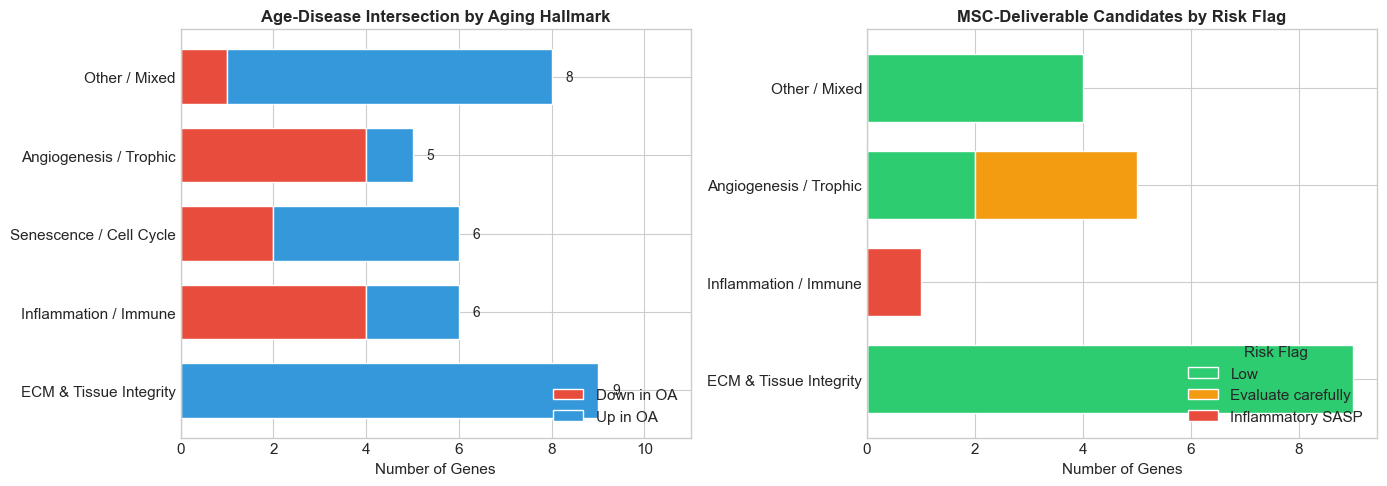


INVESTOR-READY SUMMARY TABLE

Hallmark                        Total  Secreted   Low Risk
----------------------------------------------------------------------
ECM & Tissue Integrity              9         9          9
Inflammation / Immune               6         1          4
Senescence / Cell Cycle             6         0          3
Angiogenesis / Trophic              5         5          2
Other / Mixed                       8         4          8
----------------------------------------------------------------------
TOTAL                              34        19         26

Cell 4D complete. Ready for Cell 5.


In [7]:
"""
CELL 4D: RISK FLAGGING & SUMMARY VISUALIZATION
==============================================
Add lightweight risk annotations and create investor-ready summary.
"""

print("RISK FLAGGING & SUMMARY")
print("="*70)
print()

# -------------------------------------------------------------------------
# RISK FLAG ASSIGNMENT
# -------------------------------------------------------------------------

def assign_risk_flag(row):
    """
    Assign risk flag for therapeutic interpretation.
    """
    hallmark = row['aging_hallmark']
    in_sasp = row['in_SASP']
    therapeutic_note = row['therapeutic_note']
    
    if 'Context-dependent' in therapeutic_note:
        return 'Context-dependent'
    elif in_sasp and hallmark == 'Inflammation / Immune':
        return 'Inflammatory SASP'
    elif 'Evaluate carefully' in therapeutic_note:
        return 'Evaluate carefully'
    else:
        return 'Low'

# Apply risk flagging
intersection_df['risk_flag'] = intersection_df.apply(assign_risk_flag, axis=1)

# Display risk distribution
print("RISK FLAG DISTRIBUTION")
print("-"*70)
risk_counts = intersection_df['risk_flag'].value_counts()
for risk, count in risk_counts.items():
    print(f"   {risk:<25} {count:>3} genes")

print()

# -------------------------------------------------------------------------
# SUMMARY VISUALIZATION
# -------------------------------------------------------------------------

print("GENERATING HALLMARK SUMMARY VISUALIZATION")
print("-"*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Genes by Hallmark
ax1 = axes[0]
hallmark_order = ['ECM & Tissue Integrity', 'Inflammation / Immune', 
                  'Senescence / Cell Cycle', 'Angiogenesis / Trophic', 'Other / Mixed']

hallmark_direction = intersection_df.groupby(['aging_hallmark', 'direction']).size().unstack(fill_value=0)
hallmark_direction = hallmark_direction.reindex([h for h in hallmark_order if h in hallmark_direction.index])

hallmark_direction.plot(kind='barh', stacked=True, ax=ax1, 
                        color=['#E74C3C', '#3498DB'], edgecolor='white', width=0.7)
ax1.set_xlabel('Number of Genes', fontsize=11)
ax1.set_ylabel('')
ax1.set_title('Age-Disease Intersection by Aging Hallmark', fontsize=12, fontweight='bold')
ax1.legend(['Down in OA', 'Up in OA'], loc='lower right', framealpha=0.9)
ax1.set_xlim(0, max(hallmark_direction.sum(axis=1)) + 2)

for i, (idx, row) in enumerate(hallmark_direction.iterrows()):
    total = row.sum()
    ax1.text(total + 0.3, i, str(int(total)), va='center', fontsize=10)

# Panel B: Secreted Candidates by Risk
ax2 = axes[1]
secreted_df = intersection_df[intersection_df['is_secreted'] == True]

if len(secreted_df) > 0:
    secreted_summary = secreted_df.groupby(['aging_hallmark', 'risk_flag']).size().unstack(fill_value=0)
    
    risk_order = ['Low', 'Evaluate carefully', 'Context-dependent', 'Inflammatory SASP']
    available_risks = [r for r in risk_order if r in secreted_summary.columns]
    secreted_summary = secreted_summary[available_risks]
    secreted_summary = secreted_summary.reindex([h for h in hallmark_order if h in secreted_summary.index])
    
    risk_colors = {'Low': '#2ECC71', 'Evaluate carefully': '#F39C12', 
                   'Context-dependent': '#9B59B6', 'Inflammatory SASP': '#E74C3C'}
    colors_to_use = [risk_colors.get(r, '#95A5A6') for r in available_risks]
    
    secreted_summary.plot(kind='barh', stacked=True, ax=ax2, 
                          color=colors_to_use, edgecolor='white', width=0.7)
    ax2.set_xlabel('Number of Genes', fontsize=11)
    ax2.set_ylabel('')
    ax2.set_title('MSC-Deliverable Candidates by Risk Flag', fontsize=12, fontweight='bold')
    ax2.legend(title='Risk Flag', loc='lower right', framealpha=0.9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'hallmark_risk_summary.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
print(f"   Saved: {FIGURES_DIR / 'hallmark_risk_summary.png'}")
plt.show()

# -------------------------------------------------------------------------
# SUMMARY TABLE
# -------------------------------------------------------------------------

print()
print("INVESTOR-READY SUMMARY TABLE")
print("="*70)
print()
print(f"{'Hallmark':<30} {'Total':>6} {'Secreted':>9} {'Low Risk':>10}")
print("-"*70)

for hallmark in hallmark_order:
    subset = intersection_df[intersection_df['aging_hallmark'] == hallmark]
    total = len(subset)
    secreted = len(subset[subset['is_secreted'] == True])
    low_risk = len(subset[subset['risk_flag'] == 'Low'])
    if total > 0:
        print(f"{hallmark:<30} {total:>6} {secreted:>9} {low_risk:>10}")

print("-"*70)
total_secreted = len(intersection_df[intersection_df['is_secreted'] == True])
total_low_risk = len(intersection_df[intersection_df['risk_flag'] == 'Low'])
print(f"{'TOTAL':<30} {len(intersection_df):>6} {total_secreted:>9} {total_low_risk:>10}")

print()
print("Cell 4D complete. Ready for Cell 5.")

---
## Cell 5: Filter for Secreted Factors (MSC-Deliverable)

In [8]:
"""
CELL 5: FILTER FOR SECRETED FACTORS (MSC-DELIVERABLE)
=====================================================
Focus on genes encoding secreted proteins that MSCs could deliver.
This is the core Kairos therapeutic modality filter.
"""

print("FILTERING FOR SECRETED FACTORS (MSC-DELIVERABLE)")
print("="*70)
print()
print("Therapeutic rationale: MSCs can deliver secreted factors to diseased tissue")
print()

# Filter intersection for secreted factors
secreted_candidates = intersection_df[intersection_df['is_secreted'] == True].copy()

print(f"Age-disease intersection genes: {len(intersection_df)}")
print(f"Secreted factors (MSC-deliverable): {len(secreted_candidates)}")
print()

# Breakdown by direction
secreted_up = secreted_candidates[secreted_candidates['direction'] == 'Up in OA']
secreted_down = secreted_candidates[secreted_candidates['direction'] == 'Down in OA']

print(f"Secreted candidates by direction:")
print(f"   Disease-elevated (consider MSC-delivered INHIBITORS): {len(secreted_up)}")
print(f"   Protective loss (consider MSC-delivered FACTORS): {len(secreted_down)}")
print()

# Add intervention strategy
secreted_candidates['intervention'] = secreted_candidates['direction'].apply(
    lambda x: 'MSC-delivered inhibitor/antagonist' if x == 'Up in OA' else 'MSC-delivered factor'
)

# -------------------------------------------------------------------------
# AGING EVIDENCE SCORING RATIONALE
# -------------------------------------------------------------------------
# GenAge (weight 2): Genes with established causal evidence for longevity/aging
#   from model organism lifespan studies and human GWAS. Higher weight because
#   these represent validated aging biology with mechanistic evidence.
#   Source: genomics.senescence.info (Human Ageing Genomic Resources)
#
# SenMayo (weight 1): Validated senescence markers reproducible across tissues
#   and experimental conditions. Represents cellular aging phenotype.
#   Source: Saul et al., Aging Cell 2022 (125-gene consensus panel)
#
# SASP (weight 1): Senescence-Associated Secretory Phenotype factors that are
#   actively secreted. Important for MSC delivery relevance.
#   Source: Coppe et al. consensus SASP list + literature curation
#
# Note: This is a simple additive score for V0. Notebook 06 will incorporate
# druggability, tissue specificity, and therapeutic feasibility weighting.
# -------------------------------------------------------------------------

# Add priority score based on aging evidence strength
secreted_candidates['aging_evidence_score'] = (
    secreted_candidates['in_GenAge'].astype(int) * 2 +  # GenAge = established, weight 2
    secreted_candidates['in_SenMayo'].astype(int) * 1 +  # SenMayo = senescence marker
    secreted_candidates['in_SASP'].astype(int) * 1  # SASP = secreted factor
)

secreted_candidates = secreted_candidates.sort_values(
    ['aging_evidence_score', 'log2FC'], 
    ascending=[False, False],
    key=lambda x: abs(x) if x.name == 'log2FC' else x
)

print(f"Top secreted candidates by aging evidence:")
print("-"*70)
print(f"{'Gene':<12} {'log2FC':>8} {'Direction':<25} {'Aging Score':>12}")
print("-"*70)

for _, row in secreted_candidates.head(15).iterrows():
    direction_short = 'Disease-elevated' if row['direction'] == 'Up in OA' else 'Protective loss'
    print(f"{row['gene']:<12} {row['log2FC']:>8.2f} {direction_short:<25} {row['aging_evidence_score']:>12}")

print()
print("Cell 5 complete. Ready for Cell 6.")

FILTERING FOR SECRETED FACTORS (MSC-DELIVERABLE)

Therapeutic rationale: MSCs can deliver secreted factors to diseased tissue

Age-disease intersection genes: 34
Secreted factors (MSC-deliverable): 19

Secreted candidates by direction:
   Disease-elevated (consider MSC-delivered INHIBITORS): 15
   Protective loss (consider MSC-delivered FACTORS): 4

Top secreted candidates by aging evidence:
----------------------------------------------------------------------
Gene           log2FC Direction                  Aging Score
----------------------------------------------------------------------
MMP13            3.20 Disease-elevated                     2
IGFBP3           2.96 Disease-elevated                     2
VEGFA           -2.56 Protective loss                      2
SPP1             2.51 Disease-elevated                     2
SERPINE2         2.03 Disease-elevated                     2
LIF             -1.80 Protective loss                      2
MMP9             1.42 Disease-elevat

---
## Cell 6: Visualize Age-Disease Intersection

GENERATING VISUALIZATIONS

   Saved: C:\Users\povan\Kairos_Therapeutics\reports\figures\age_disease_intersection.png


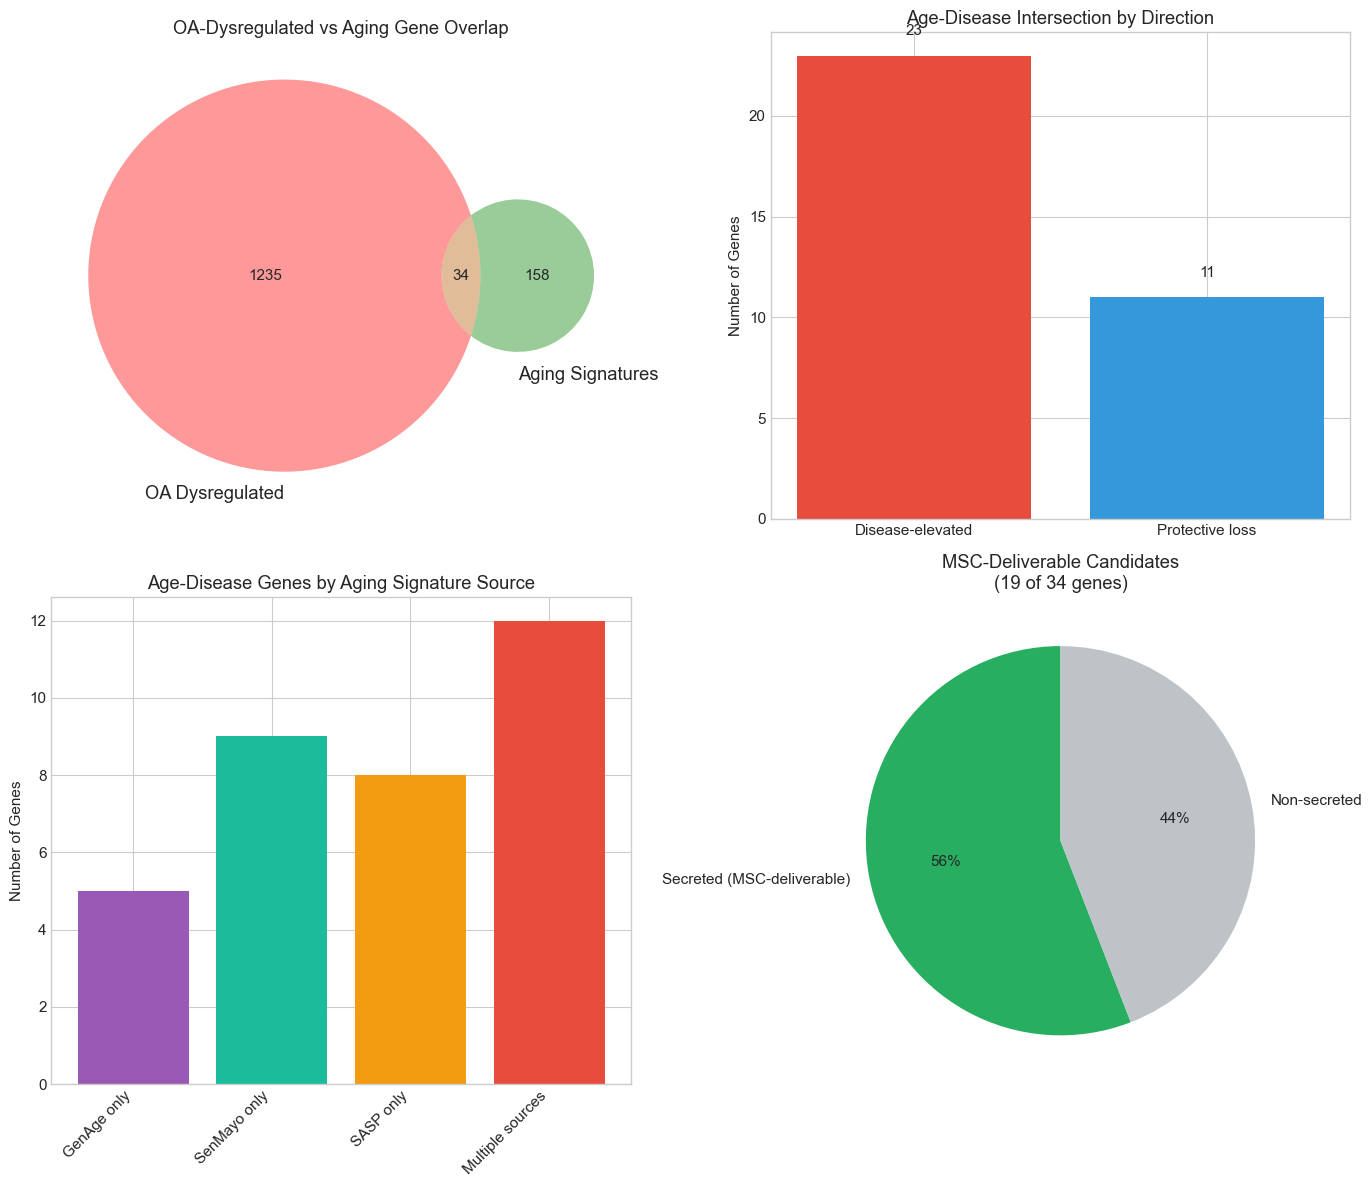


Cell 6 complete. Ready for Cell 7.


In [9]:
"""
CELL 6: VISUALIZE AGE-DISEASE INTERSECTION
==========================================
Create Venn diagram and summary plots.
"""

print("GENERATING VISUALIZATIONS")
print("="*70)
print()

# Check if matplotlib_venn is installed
try:
    from matplotlib_venn import venn2, venn3
    has_venn = True
except ImportError:
    print("Note: matplotlib_venn not installed. Using alternative visualization.")
    has_venn = False

# Create figure with multiple panels
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Panel A: OA vs Aging intersection (bar chart if no venn)
ax1 = axes[0, 0]
if has_venn:
    venn2([oa_sig_genes, ALL_AGING_GENES], 
          set_labels=('OA Dysregulated', 'Aging Signatures'),
          ax=ax1)
    ax1.set_title('OA-Dysregulated vs Aging Gene Overlap')
else:
    # Bar chart alternative
    categories = ['OA Only', 'Intersection', 'Aging Only']
    values = [len(oa_sig_genes - ALL_AGING_GENES), 
              len(oa_sig_genes & ALL_AGING_GENES),
              len(ALL_AGING_GENES - oa_sig_genes)]
    ax1.bar(categories, values, color=['#3498db', '#e74c3c', '#95a5a6'])
    ax1.set_ylabel('Number of Genes')
    ax1.set_title('OA-Dysregulated vs Aging Gene Overlap')
    for i, v in enumerate(values):
        ax1.text(i, v + 10, str(v), ha='center', fontsize=11)

# Panel B: Intersection breakdown by direction
ax2 = axes[0, 1]
direction_counts = intersection_df['direction'].value_counts()
colors = ['#e74c3c' if 'Up' in x else '#3498db' for x in direction_counts.index]
bars = ax2.bar(range(len(direction_counts)), direction_counts.values, color=colors)
ax2.set_xticks(range(len(direction_counts)))
ax2.set_xticklabels(['Disease-elevated' if 'Up' in x else 'Protective loss' for x in direction_counts.index])
ax2.set_ylabel('Number of Genes')
ax2.set_title('Age-Disease Intersection by Direction')
for bar, val in zip(bars, direction_counts.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, str(val), ha='center')

# Panel C: Aging signature source overlap
ax3 = axes[1, 0]
source_counts = {
    'GenAge only': len(intersection_genage - intersection_senmayo - intersection_sasp),
    'SenMayo only': len(intersection_senmayo - intersection_genage - intersection_sasp),
    'SASP only': len(intersection_sasp - intersection_genage - intersection_senmayo),
    'Multiple sources': len([g for g in intersection_all if sum([g in GENAGE_GENES, g in SENMAYO_GENES, g in SASP_GENES]) > 1]),
}
ax3.bar(source_counts.keys(), source_counts.values(), color=['#9b59b6', '#1abc9c', '#f39c12', '#e74c3c'])
ax3.set_ylabel('Number of Genes')
ax3.set_title('Age-Disease Genes by Aging Signature Source')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Panel D: Secreted vs Non-secreted
ax4 = axes[1, 1]
secreted_counts = intersection_df['is_secreted'].value_counts()
labels = ['Secreted (MSC-deliverable)', 'Non-secreted']
colors = ['#27ae60', '#bdc3c7']
wedges, texts, autotexts = ax4.pie(
    [secreted_counts.get(True, 0), secreted_counts.get(False, 0)],
    labels=labels,
    colors=colors,
    autopct='%1.0f%%',
    startangle=90
)
ax4.set_title(f'MSC-Deliverable Candidates\n({secreted_counts.get(True, 0)} of {len(intersection_df)} genes)')

plt.tight_layout()

# Save figure
fig_path = FIGURES_DIR / 'age_disease_intersection.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"   Saved: {fig_path}")

plt.show()

print()
print("Cell 6 complete. Ready for Cell 7.")

---
## Cell 7: Highlight Key Therapeutic Candidates

In [10]:
"""
CELL 7: HIGHLIGHT KEY THERAPEUTIC CANDIDATES
============================================
Focus on specific high-value targets with biological rationale.
"""

print("KEY THERAPEUTIC CANDIDATES")
print("="*70)
print()

# Check for PF4 (the company's lead candidate)
pf4_present = 'PF4' in intersection_df['gene'].values or 'CXCL4' in intersection_df['gene'].values

print("SPOTLIGHT: PF4 (Platelet Factor 4 / CXCL4)")
print("-"*70)
if pf4_present:
    pf4_data = intersection_df[intersection_df['gene'].isin(['PF4', 'CXCL4'])]
    for _, row in pf4_data.iterrows():
        print(f"   Gene: {row['gene']}")
        print(f"   log2FC: {row['log2FC']:.2f}")
        print(f"   Direction: {row['direction']}")
        print(f"   In GenAge: {row['in_GenAge']}")
        print(f"   Is Secreted: {row['is_secreted']}")
else:
    # Check if PF4 is in DE results at all
    if de_results is not None:
        pf4_de = de_results[de_results['gene'].isin(['PF4', 'CXCL4'])]
        if len(pf4_de) > 0:
            print("   PF4 is in DE results but NOT significantly dysregulated in OA cartilage.")
            print(f"   This is EXPECTED - PF4 is a platelet-derived factor not made by chondrocytes.")
            print(f"   Therapeutic rationale: MSC-delivered PF4 provides a factor the tissue lacks.")
            for _, row in pf4_de.iterrows():
                print(f"   log2FC: {row['log2FC']:.3f}, p-value: {row['p_value']:.3f}")
        else:
            print("   PF4 not found in dataset (may use different gene symbol)")
print()

# Top secreted candidates for restoration (MSC can deliver these)
print("TOP MSC-DELIVERABLE CANDIDATES FOR RESTORATION")
print("-"*70)
restore_candidates = secreted_candidates[secreted_candidates['direction'] == 'Down in OA'].head(10)

for _, row in restore_candidates.iterrows():
    sources = []
    if row['in_GenAge']: sources.append('GenAge')
    if row['in_SenMayo']: sources.append('SenMayo')
    if row['in_SASP']: sources.append('SASP')
    print(f"   {row['gene']}: log2FC={row['log2FC']:.2f} | Sources: {', '.join(sources)}")

print()

# Top secreted candidates for inhibition (MSC can deliver antagonists)
print("TOP MSC-DELIVERABLE CANDIDATES FOR INHIBITION")
print("-"*70)
inhibit_candidates = secreted_candidates[secreted_candidates['direction'] == 'Up in OA'].head(10)

for _, row in inhibit_candidates.iterrows():
    sources = []
    if row['in_GenAge']: sources.append('GenAge')
    if row['in_SenMayo']: sources.append('SenMayo')
    if row['in_SASP']: sources.append('SASP')
    print(f"   {row['gene']}: log2FC={row['log2FC']:.2f} | Sources: {', '.join(sources)}")

print()
print("Cell 7 complete. Ready for Cell 8.")

KEY THERAPEUTIC CANDIDATES

SPOTLIGHT: PF4 (Platelet Factor 4 / CXCL4)
----------------------------------------------------------------------
   PF4 is in DE results but NOT significantly dysregulated in OA cartilage.
   This is EXPECTED - PF4 is a platelet-derived factor not made by chondrocytes.
   Therapeutic rationale: MSC-delivered PF4 provides a factor the tissue lacks.
   log2FC: 0.057, p-value: 0.231

TOP MSC-DELIVERABLE CANDIDATES FOR RESTORATION
----------------------------------------------------------------------
   VEGFA: log2FC=-2.56 | Sources: SenMayo, SASP
   LIF: log2FC=-1.80 | Sources: SenMayo, SASP
   ANGPTL4: log2FC=-2.74 | Sources: SASP
   FST: log2FC=-1.17 | Sources: SASP

TOP MSC-DELIVERABLE CANDIDATES FOR INHIBITION
----------------------------------------------------------------------
   MMP13: log2FC=3.20 | Sources: SenMayo, SASP
   IGFBP3: log2FC=2.96 | Sources: SenMayo, SASP
   SPP1: log2FC=2.51 | Sources: SenMayo, SASP
   SERPINE2: log2FC=2.03 | Sources: Se

---
## Cell 8: Create Secreted Candidates Plot

GENERATING SECRETED CANDIDATES PLOT

   Saved: C:\Users\povan\Kairos_Therapeutics\reports\figures\secreted_candidates_plot.png


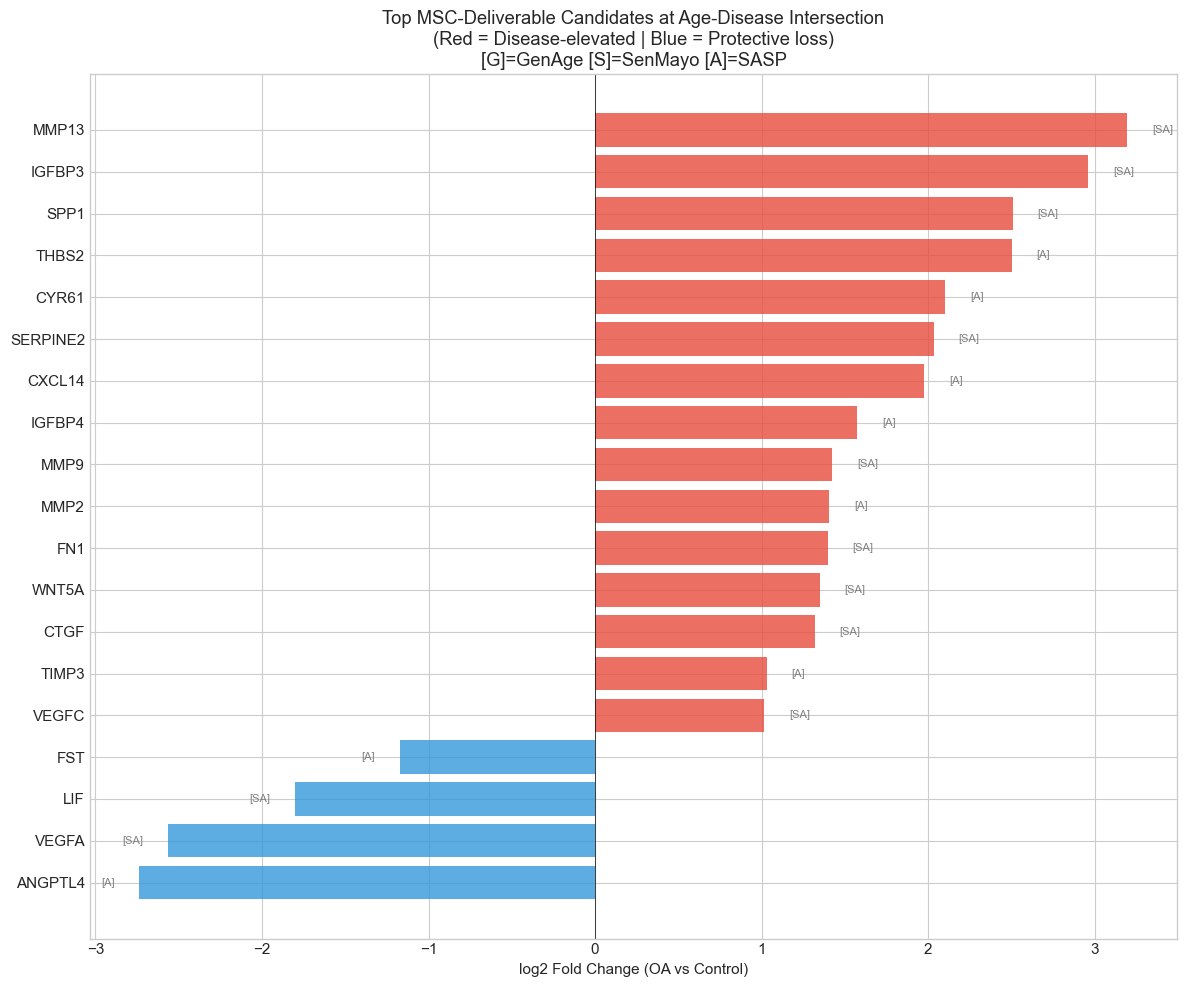


Cell 8 complete. Ready for Cell 9.


In [11]:
"""
CELL 8: CREATE SECRETED CANDIDATES PLOT
=======================================
Visualization of top MSC-deliverable candidates.
"""

print("GENERATING SECRETED CANDIDATES PLOT")
print("="*70)
print()

# Select top candidates by absolute log2FC
plot_candidates = secreted_candidates.copy()
plot_candidates['abs_log2FC'] = plot_candidates['log2FC'].abs()
plot_candidates = plot_candidates.nlargest(30, 'abs_log2FC')
plot_candidates = plot_candidates.sort_values('log2FC')

# Create horizontal bar plot
fig, ax = plt.subplots(figsize=(12, 10))

colors = ['#e74c3c' if x > 0 else '#3498db' for x in plot_candidates['log2FC']]

bars = ax.barh(range(len(plot_candidates)), plot_candidates['log2FC'], color=colors, alpha=0.8)

# Add gene names
ax.set_yticks(range(len(plot_candidates)))
ax.set_yticklabels(plot_candidates['gene'])

# Add aging evidence markers
for i, (_, row) in enumerate(plot_candidates.iterrows()):
    marker = ''
    if row['in_GenAge']: marker += 'G'
    if row['in_SenMayo']: marker += 'S'
    if row['in_SASP']: marker += 'A'
    if marker:
        x_pos = row['log2FC'] + (0.15 if row['log2FC'] > 0 else -0.15)
        ax.text(x_pos, i, f'[{marker}]', va='center', 
                ha='left' if row['log2FC'] > 0 else 'right', fontsize=8, color='gray')

ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('log2 Fold Change (OA vs Control)')
ax.set_title('Top MSC-Deliverable Candidates at Age-Disease Intersection\n'
             '(Red = Disease-elevated | Blue = Protective loss)\n'
             '[G]=GenAge [S]=SenMayo [A]=SASP')

plt.tight_layout()

# Save figure
fig_path = FIGURES_DIR / 'secreted_candidates_plot.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"   Saved: {fig_path}")

plt.show()

print()
print("Cell 8 complete. Ready for Cell 9.")

---
## Cell 9: Save Results

In [12]:
"""
CELL 9: SAVE RESULTS
====================
Export all results for downstream analysis.
"""

print("SAVING RESULTS")
print("="*70)
print()

# Save aging signatures reference
aging_sig_path = DATA_PROCESSED / 'aging_gene_signatures.csv'
aging_signatures_df.to_csv(aging_sig_path, index=False)
print(f"   Aging signatures: {aging_sig_path}")

# Save age-disease intersection
intersection_path = DATA_PROCESSED / 'age_disease_intersection.csv'
intersection_df.to_csv(intersection_path, index=False)
print(f"   Age-disease intersection: {intersection_path}")

# Save secreted candidates
secreted_path = DATA_PROCESSED / 'secreted_candidates.csv'
secreted_candidates.to_csv(secreted_path, index=False)
print(f"   Secreted candidates: {secreted_path}")

print()
print("Cell 9 complete. Ready for Cell 10.")

SAVING RESULTS

   Aging signatures: C:\Users\povan\Kairos_Therapeutics\data\processed\aging_gene_signatures.csv
   Age-disease intersection: C:\Users\povan\Kairos_Therapeutics\data\processed\age_disease_intersection.csv
   Secreted candidates: C:\Users\povan\Kairos_Therapeutics\data\processed\secreted_candidates.csv

Cell 9 complete. Ready for Cell 10.


---
## Cell 10: Summary Report

In [13]:
"""
CELL 10: SUMMARY REPORT
=======================
Generate comprehensive summary.
"""

print("GENERATING SUMMARY REPORT")
print("="*70)
print()

report_lines = []
report_lines.append("="*70)
report_lines.append("KAIROS ML PROTOTYPE V0 - AGE-DISEASE INTERSECTION ANALYSIS")
report_lines.append(f"Dataset: GSE114007 (Knee Cartilage OA vs Control)")
report_lines.append(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
report_lines.append("="*70)
report_lines.append("")

report_lines.append("STRATEGIC CONTEXT")
report_lines.append("-"*40)
report_lines.append("Kairos: Causal gene-intervention discovery for aging biology")
report_lines.append("This analysis finds genes at the intersection of:")
report_lines.append("  1. Disease dysregulation (OA vs Control)")
report_lines.append("  2. Aging biology (GenAge, SenMayo, SASP signatures)")
report_lines.append("  3. MSC-deliverable (secreted factors)")
report_lines.append("")

report_lines.append("AGING SIGNATURES USED")
report_lines.append("-"*40)
report_lines.append(f"  GenAge (established aging genes): {len(GENAGE_GENES)}")
report_lines.append(f"  SenMayo (senescence markers): {len(SENMAYO_GENES)}")
report_lines.append(f"  SASP (secretory phenotype): {len(SASP_GENES)}")
report_lines.append(f"  Combined unique genes: {len(ALL_AGING_GENES)}")
report_lines.append("")

report_lines.append("INTERSECTION RESULTS")
report_lines.append("-"*40)
report_lines.append(f"  OA-dysregulated genes: {len(oa_sig_genes)}")
report_lines.append(f"  Age-disease intersection: {len(intersection_df)}")
report_lines.append(f"  - Disease-elevated: {len(intersection_df[intersection_df['direction'] == 'Up in OA'])}")
report_lines.append(f"  - Protective loss: {len(intersection_df[intersection_df['direction'] == 'Down in OA'])}")
report_lines.append("")

report_lines.append("MSC-DELIVERABLE CANDIDATES")
report_lines.append("-"*40)
report_lines.append(f"  Secreted factors at intersection: {len(secreted_candidates)}")
report_lines.append(f"  - For restoration (MSC-delivered factor): {len(secreted_down)}")
report_lines.append(f"  - For inhibition (MSC-delivered antagonist): {len(secreted_up)}")
report_lines.append("")

# -------------------------------------------------------------------------
# INTERPRETATION NOTES SECTION
# -------------------------------------------------------------------------
report_lines.append("INTERPRETATION NOTES")
report_lines.append("-"*40)
report_lines.append("  ⚠️  Directionality is biologically context-dependent:")
report_lines.append("")
report_lines.append("  SENESCENCE MARKERS (CDKN1A, GLB1, CDKN2B):")
report_lines.append("    - 'Down in OA' may NOT indicate loss of protection")
report_lines.append("    - Could reflect reduced senescent cell burden")
report_lines.append("    - Requires careful evaluation before targeting")
report_lines.append("")
report_lines.append("  SASP FACTORS:")
report_lines.append("    - Restoration of pro-inflammatory factors could worsen disease")
report_lines.append("    - Flagged for careful evaluation in Notebook 06")
report_lines.append("")
report_lines.append("  RISK FLAG SUMMARY:")
risk_summary = intersection_df['risk_flag'].value_counts()
for risk, count in risk_summary.items():
    report_lines.append(f"    {risk}: {count} genes")
report_lines.append("")
report_lines.append("  AGING HALLMARK SUMMARY:")
hallmark_summary = intersection_df['aging_hallmark'].value_counts()
for hallmark, count in hallmark_summary.items():
    report_lines.append(f"    {hallmark}: {count} genes")
report_lines.append("")
report_lines.append("  PRIORITY FOR MSC DELIVERY (Notebook 06):")
report_lines.append("    1. Low-risk secreted factors (VEGFA, FST)")
report_lines.append("    2. MMP inhibitors (clear disease-elevated targets)")
report_lines.append("    3. Context-dependent factors require deeper analysis")
report_lines.append("")

report_lines.append("TOP RESTORATION CANDIDATES (MSC-delivered factors)")
report_lines.append("-"*40)
for _, row in secreted_candidates[secreted_candidates['direction'] == 'Down in OA'].head(10).iterrows():
    report_lines.append(f"  {row['gene']}: log2FC={row['log2FC']:.2f}")
report_lines.append("")

report_lines.append("TOP INHIBITION CANDIDATES (MSC-delivered antagonists)")
report_lines.append("-"*40)
for _, row in secreted_candidates[secreted_candidates['direction'] == 'Up in OA'].head(10).iterrows():
    report_lines.append(f"  {row['gene']}: log2FC={row['log2FC']:.2f}")
report_lines.append("")

report_lines.append("OUTPUT FILES")
report_lines.append("-"*40)
report_lines.append("  aging_gene_signatures.csv")
report_lines.append("  age_disease_intersection.csv")
report_lines.append("  secreted_candidates.csv")
report_lines.append("  age_disease_intersection.png")
report_lines.append("  secreted_candidates_plot.png")
report_lines.append("  hallmark_risk_summary.png")
report_lines.append("")

report_lines.append("NEXT STEPS")
report_lines.append("-"*40)
report_lines.append("  1. Notebook 06: Therapeutic Target Prioritization")
report_lines.append("  2. Rank candidates by druggability, effect size, aging evidence")
report_lines.append("  3. Build Streamlit demo for investors")
report_lines.append("")
report_lines.append("="*70)

# Print and save
report_text = "\n".join(report_lines)
print(report_text)

report_path = REPORTS_DIR / 'age_disease_intersection_summary.txt'
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(report_text)
print()
print(f"Report saved: {report_path}")

print()
print("Cell 10 complete. Ready for Cell 11.")

GENERATING SUMMARY REPORT

KAIROS ML PROTOTYPE V0 - AGE-DISEASE INTERSECTION ANALYSIS
Dataset: GSE114007 (Knee Cartilage OA vs Control)
Generated: 2025-12-26 22:41:23

STRATEGIC CONTEXT
----------------------------------------
Kairos: Causal gene-intervention discovery for aging biology
This analysis finds genes at the intersection of:
  1. Disease dysregulation (OA vs Control)
  2. Aging biology (GenAge, SenMayo, SASP signatures)
  3. MSC-deliverable (secreted factors)

AGING SIGNATURES USED
----------------------------------------
  GenAge (established aging genes): 75
  SenMayo (senescence markers): 93
  SASP (secretory phenotype): 98
  Combined unique genes: 192

INTERSECTION RESULTS
----------------------------------------
  OA-dysregulated genes: 1269
  Age-disease intersection: 34
  - Disease-elevated: 23
  - Protective loss: 11

MSC-DELIVERABLE CANDIDATES
----------------------------------------
  Secreted factors at intersection: 19
  - For restoration (MSC-delivered factor): 

---
## Cell 11: Final Checkpoint

In [14]:
"""
CELL 11: FINAL CHECKPOINT
=========================
Summary and next steps.
"""

print("="*70)
print("NOTEBOOK 05 COMPLETE - FINAL CHECKPOINT")
print("="*70)
print()

print("KEY FINDINGS:")
print("-"*40)
print(f"   OA-dysregulated genes: {len(oa_sig_genes)}")
print(f"   Age-disease intersection: {len(intersection_df)}")
print(f"   MSC-deliverable candidates: {len(secreted_candidates)}")
print()

print("AGING HALLMARKS REPRESENTED:")
print("-"*40)
print(f"   GenAge intersection: {len(intersection_genage)} genes")
print(f"   SenMayo intersection: {len(intersection_senmayo)} genes")
print(f"   SASP intersection: {len(intersection_sasp)} genes")
print()

print("OUTPUT FILES:")
print("-"*40)
output_files = [
    DATA_PROCESSED / 'aging_gene_signatures.csv',
    DATA_PROCESSED / 'age_disease_intersection.csv',
    DATA_PROCESSED / 'secreted_candidates.csv',
    FIGURES_DIR / 'age_disease_intersection.png',
    FIGURES_DIR / 'secreted_candidates_plot.png',
]
for f in output_files:
    if f.exists():
        size_kb = f.stat().st_size / 1024
        print(f"   {f.name} ({size_kb:.1f} KB)")

print()
print("NEXT STEPS:")
print("-"*40)
print("   1. Commit this notebook to GitHub")
print("   2. Notebook 06: Therapeutic Target Prioritization")
print("   3. Build Streamlit investor demo")

print()
print("GIT COMMANDS:")
print("-"*40)
print('   git add notebooks/Notebook_05_Age_Disease_Intersection.ipynb')
print('   git add reports/')
print('   git commit -m "Add Notebook 05: Age-Disease Intersection Analysis"')
print('   git push origin main')

print()
print(f"Completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*70)

NOTEBOOK 05 COMPLETE - FINAL CHECKPOINT

KEY FINDINGS:
----------------------------------------
   OA-dysregulated genes: 1269
   Age-disease intersection: 34
   MSC-deliverable candidates: 19

AGING HALLMARKS REPRESENTED:
----------------------------------------
   GenAge intersection: 6 genes
   SenMayo intersection: 21 genes
   SASP intersection: 19 genes

OUTPUT FILES:
----------------------------------------
   aging_gene_signatures.csv (5.5 KB)
   age_disease_intersection.csv (4.8 KB)
   secreted_candidates.csv (3.4 KB)
   age_disease_intersection.png (153.1 KB)
   secreted_candidates_plot.png (91.3 KB)

NEXT STEPS:
----------------------------------------
   1. Commit this notebook to GitHub
   2. Notebook 06: Therapeutic Target Prioritization
   3. Build Streamlit investor demo

GIT COMMANDS:
----------------------------------------
   git add notebooks/Notebook_05_Age_Disease_Intersection.ipynb
   git add reports/
   git commit -m "Add Notebook 05: Age-Disease Intersection Ana

---
## End of Notebook 05

**Summary:**
- Integrated multiple aging gene signatures (GenAge, SenMayo, SASP)
- Identified genes at intersection of OA dysregulation AND aging biology
- Filtered for MSC-deliverable secreted factors
- Created prioritized list for therapeutic target selection

**Strategic Achievement:**
- Connected disease biology to aging biology with gene-level evidence
- Identified MSC-deliverable candidates for Kairos therapeutic platform
- Foundation for target prioritization and investor demo

**Next:** Notebook 06 - Therapeutic Target Prioritization